<a href="https://colab.research.google.com/github/sunnyday2/flight_on_time/blob/desarrollo/flightontime_hackaton_e32_alura_latam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---------

# **1. 📚 Librerías y configuración**
---

In [1]:
!pip install kagglehub pyarrow requests

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (
    classification_report,
    roc_curve,
    roc_auc_score,
    auc
)

import joblib
import kagglehub
import pyarrow as pa
import pyarrow.parquet as pq
import os
import requests


sns.set(style="whitegrid")

## Descargar el dataset de Rafael para el analisis e entrenamiento

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extraer porciones de data por años

In [4]:
path = kagglehub.dataset_download("arvindnagaonkar/flight-delay")
print("Dataset descargado en:")
print(path)

# Lista los archivos disponibles dentro del dataset descargado
os.listdir(path)

# Construimos la ruta al archivo parquet
# ParquetFile permite leer el dataset sin cargarlo entero en memoria
PARQUET_FILE = os.path.join(path, "Flight_Delay.parquet")

OUT_FILE = "df_sample_equal_year.parquet"

BATCH_SIZE = 200_000
YEAR_COL = "Year"

# -------- 1) Primer pase: contar filas por Year (streaming) --------
pf = pq.ParquetFile(PARQUET_FILE)
counts = {}

for batch in pf.iter_batches(batch_size=BATCH_SIZE, columns=[YEAR_COL]):
    years = batch.column(0).to_numpy()
    uniq, cnt = np.unique(years, return_counts=True)
    for y, c in zip(uniq, cnt):
        counts[int(y)] = counts.get(int(y), 0) + int(c)

min_per_year = min(counts.values())  # mismo tamaño por Year

# (opcional) si quieres una fracción del mínimo:
# SAMPLE_FRAC = 0.10
# min_per_year = int(min_per_year * SAMPLE_FRAC)

print("Counts:", counts)
print("Rows per Year to keep:", min_per_year)

# -------- 2) Segundo pase: construir salida con N filas por Year --------
pf = pq.ParquetFile(PARQUET_FILE)

kept = {y: 0 for y in counts.keys()}
writer = None

for batch in pf.iter_batches(batch_size=BATCH_SIZE):  # lee todas las columnas
    df_chunk = batch.to_pandas()

    # seleccionar filas manteniendo cupo por year
    parts = []
    for y, g in df_chunk.groupby(YEAR_COL, sort=False):
        y = int(y)
        remaining = min_per_year - kept.get(y, 0)
        if remaining <= 0:
            continue
        take = g.iloc[:remaining]  # determinístico (primeras filas)
        kept[y] = kept.get(y, 0) + len(take)
        parts.append(take)

    if not parts:
        # si no hay nada que guardar de este batch, seguir
        continue

    out_df = pd.concat(parts, ignore_index=True)
    out_table = pa.Table.from_pandas(out_df, preserve_index=False)

    if writer is None:
        writer = pq.ParquetWriter(OUT_FILE, out_table.schema)
    writer.write_table(out_table)

    # early stop: si ya completaste todos los años, corta
    if all(v >= min_per_year for v in kept.values()):
        break

if writer is not None:
    writer.close()

print("Done. Written:", OUT_FILE)
print("Kept:", kept)

Using Colab cache for faster access to the 'flight-delay' dataset.
Dataset descargado en:
/kaggle/input/flight-delay
Counts: {2018: 6438556, 2019: 6707642, 2020: 4148123, 2021: 5234456, 2022: 5706055, 2023: 1897840}
Rows per Year to keep: 1897840
Done. Written: df_sample_equal_year.parquet
Kept: {2018: 1897840, 2019: 1897840, 2020: 1897840, 2021: 1897840, 2022: 1897840, 2023: 1897840}


Leemos el archivo de parquet con data reducida por años

In [5]:
print('Data source import complete.')
print ('Wait. Reading data...')
df = pd.read_parquet(OUT_FILE)

print("Finished reading data.")

Data source import complete.
Wait. Reading data...
Finished reading data.


## Cargar dataset por bloques

Cambiamos los nombres de las columnas a minúscula

In [6]:
df.columns = df.columns.str.lower()


## **Inspección visual**




### Visualizar las primeras 5 filas.

In [7]:
df.head()

,year,month,dayofmonth,flightdate,marketing_airline_network,origincityname,destcityname,crsdeptime,deptime,depdelay,...,crselapsedtime,actualelapsedtime,airtime,distance,distancegroup,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay
0,2018,1,15,2018-01-15,UA,"Newark, NJ","Charleston, SC",1845,1928.0,43.0,...,143.0,141.0,102.0,628.0,3,41.0,0.0,0.0,0.0,0.0
1,2018,1,16,2018-01-16,UA,"Newark, NJ","Charleston, SC",1835,1956.0,81.0,...,143.0,131.0,108.0,628.0,3,67.0,0.0,0.0,0.0,2.0
2,2018,1,17,2018-01-17,UA,"Newark, NJ","Charleston, SC",1835,1836.0,1.0,...,143.0,138.0,113.0,628.0,3,0.0,0.0,0.0,0.0,0.0
3,2018,1,18,2018-01-18,UA,"Newark, NJ","Charleston, SC",1845,1844.0,-1.0,...,143.0,134.0,92.0,628.0,3,0.0,0.0,0.0,0.0,0.0
4,2018,1,20,2018-01-20,UA,"Newark, NJ","Charleston, SC",1835,1829.0,-6.0,...,143.0,117.0,89.0,628.0,3,0.0,0.0,0.0,0.0,0.0


### **Estructura**

*   Revisar cuántas filas y columnas hay.

In [8]:
print(f"Cantidad de columnas y filas: {df.shape}")

Cantidad de columnas y filas: (11387040, 29)


*   Qué tipo de datos contiene cada una (¿son números, fechas, texto?)

In [9]:
df.dtypes

,0
year,int64
month,int64
dayofmonth,int64
flightdate,object
marketing_airline_network,object
origincityname,object
destcityname,object
crsdeptime,int64
deptime,float64
depdelay,float64


Distribución de data por años

In [10]:
df["year"].value_counts(normalize=True)

,proportion
year,
2018,0.166667
2019,0.166667
2020,0.166667
2021,0.166667
2022,0.166667
2023,0.166667


### **Estadística básica**

*   Calcular medias, medianas y desviaciones estándar para entender la distribución de los números.

In [11]:
df.describe()

,year,month,dayofmonth,crsdeptime,deptime,depdelay,depdelayminutes,taxiout,wheelsoff,wheelson,...,crselapsedtime,actualelapsedtime,airtime,distance,distancegroup,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay
count,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,...,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07,1.138704e+07
mean,2.020500e+03,7.043439e+00,1.575966e+01,1.321977e+03,1.326603e+03,9.950408e+00,1.369059e+01,1.678697e+01,1.350283e+03,1.463278e+03,...,1.395519e+02,1.324512e+02,1.081906e+02,7.743345e+02,3.571761e+00,5.092951e+00,8.002110e-01,2.728657e+00,2.584412e-02,5.176241e+00
std,1.707825e+00,4.625220e+00,8.788867e+00,4.817687e+02,4.938183e+02,5.205214e+01,5.091288e+01,9.502332e+00,4.947307e+02,5.179606e+02,...,7.108328e+01,7.062528e+01,6.888038e+01,5.805945e+02,2.283863e+00,3.443722e+01,1.600639e+01,1.496646e+01,1.544805e+00,2.731208e+01
min,2.018000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-3.420000e+02,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,...,-2.920000e+02,1.100000e+01,-1.412000e+03,1.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.019000e+03,1.000000e+00,8.000000e+00,9.150000e+02,9.190000e+02,-6.000000e+00,0.000000e+00,1.100000e+01,9.340000e+02,1.053000e+03,...,8.900000e+01,8.100000e+01,5.800000e+01,3.510000e+02,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.020500e+03,1.000000e+01,1.600000e+01,1.315000e+03,1.321000e+03,-3.000000e+00,0.000000e+00,1.400000e+01,1.335000e+03,1.500000e+03,...,1.210000e+02,1.150000e+02,9.000000e+01,6.180000e+02,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.022000e+03,1.100000e+01,2.300000e+01,1.725000e+03,1.733000e+03,3.000000e+00,3.000000e+00,1.900000e+01,1.747000e+03,1.903000e+03,...,1.700000e+02,1.620000e+02,1.370000e+02,1.011000e+03,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.023000e+03,1.200000e+01,3.100000e+01,2.359000e+03,2.400000e+03,4.413000e+03,4.413000e+03,1.439000e+03,2.400000e+03,2.400000e+03,...,1.645000e+03,7.640000e+02,7.270000e+02,5.095000e+03,1.100000e+01,4.218000e+03,2.098000e+03,1.660000e+03,1.460000e+03,2.962000e+03


# **2. Limpieza de Datos (Data Cleaning)**
---

### **Valores faltantes**

*   ¿Hay celdas vacías? Debes decidir si borras esas filas o rellenas los huecos con la media o un valor lógico.

In [12]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11387040 entries, 0 to 11387039
Data columns (total 29 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   year                       int64  
 1   month                      int64  
 2   dayofmonth                 int64  
 3   flightdate                 object 
 4   marketing_airline_network  object 
 5   origincityname             object 
 6   destcityname               object 
 7   crsdeptime                 int64  
 8   deptime                    float64
 9   depdelay                   float64
 10  depdelayminutes            float64
 11  taxiout                    float64
 12  wheelsoff                  float64
 13  wheelson                   float64
 14  taxiin                     float64
 15  crsarrtime                 int64  
 16  arrtime                    float64
 17  arrdelay                   float64
 18  arrdelayminutes            float64
 19  crselapsedtime             float64
 20  

# **3. Análisis Exploratorio de Datos (EDA)**
---

## **Detección de Outliers**

Identificar valores atípicos (por ejemplo, un sueldo de un billón de dólares en una lista de empleados comunes) que podrían arruinar el modelo.

## **Contar y mostrar outliers**

*   Contar el número de puntos de datos que están por debajo del límite inferior o por encima del límite superior para cada columna numérica. Mostrar estos conteos para indicar cuántos outliers hay en cada variable.

Para contar el número de outliers en cada columna numérica, itera a través de las columnas en `df_numeric`, aplica los límites inferior y superior definidos para identificar los outliers y almacenaré los conteos en un diccionario.



In [13]:
outlier_counts = {}

# Calculate Q1, Q3, IQR, lower_bound, and upper_bound within this cell
Q1 = df.select_dtypes(include='number').quantile(0.25)
Q3 = df.select_dtypes(include='number').quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

for column in df.select_dtypes(include='number').columns:
    # Skip Year and Month columns as they are constant in this dataset sample
    if column in ['Year', 'Month']:
        continue

    # Count outliers for each column
    num_outliers = df.select_dtypes(include='number')[(df.select_dtypes(include='number')[column] < lower_bound[column]) | (df.select_dtypes(include='number')[column] > upper_bound[column])].shape[0]
    outlier_counts[column] = num_outliers

sorted_outliers = sorted(outlier_counts.items(), key=lambda item: item[1], reverse=True)

print("Número de outliers por columna numérica")
print("****************************************\n")
for col, count in sorted_outliers:
    print(f"{col}: {count}")


Número de outliers por columna numérica
****************************************

arrdelayminutes: 2394230
depdelayminutes: 2347465
depdelay: 1874739
arrdelay: 1837224
carrierdelay: 1301757
nasdelay: 1204137
lateaircraftdelay: 1128890
taxiout: 663249
distance: 608157
taxiin: 605112
airtime: 582809
crselapsedtime: 577590
actualelapsedtime: 572656
distancegroup: 454149
weatherdelay: 127632
securitydelay: 11176
year: 0
month: 0
dayofmonth: 0
crsdeptime: 0
deptime: 0
wheelsoff: 0
wheelson: 0
crsarrtime: 0
arrtime: 0


*   Ahora que se han calculado y mostrado los conteos de outliers, el siguiente paso es visualizar estos outliers para columnas numéricas clave utilizando diagramas de caja. Esto proporcionará una representación gráfica de la distribución y la magnitud de los outliers.

## **Correlaciones**

¿Si la variable A sube, la variable B también? Esto nos dirá qué datos son realmente importantes para la predicción.

A continuación, para cada columna numérica, calculará algo llamado Rango Intercuartílico (IQR). El IQR ayuda a definir límites que nos indican qué tan lejos están los datos de lo que se considera normal. Para calcularlo, se debe encontrar dos valores especiales:

*   Q1: el primer cuartil, que es el valor que separa el 25% inferior de los datos.
*   Q3: el tercer cuartil, que separa el 25% superior de los datos.
*   Luego, se calculará el IQR restando Q1 de Q3. Para definir los límites que nos ayudarán a identificar los "outliers" (valores atípicos), se usará la siguiente fórmula: `lower_bound = Q1 - 1.5 * IQR` and `upper_bound = Q3 + 1.5 * IQR`

In [14]:

print("**************************")
print("Lower Bounds for Outliers:")
print("**************************")
print(lower_bound)
print("\n**************************")
print("Upper Bounds for Outliers:")
print("**************************")
print(upper_bound)

**************************
Lower Bounds for Outliers:
**************************
year                 2014.5
month                 -14.0
dayofmonth            -14.5
crsdeptime           -300.0
deptime              -302.0
depdelay              -19.5
depdelayminutes        -4.5
taxiout                -1.0
wheelsoff            -285.5
wheelson             -222.0
taxiin                 -3.5
crsarrtime            -94.5
arrtime              -219.5
arrdelay              -41.0
arrdelayminutes         0.0
crselapsedtime        -32.5
actualelapsedtime     -40.5
airtime               -60.5
distance             -639.0
distancegroup          -2.5
carrierdelay            0.0
weatherdelay            0.0
nasdelay                0.0
securitydelay           0.0
lateaircraftdelay       0.0
dtype: float64

**************************
Upper Bounds for Outliers:
**************************
year                 2026.5
month                  26.0
dayofmonth             45.5
crsdeptime           2940.0
deptime   

## **Tipos de retrasos más comunes**

Vamos a crear un gráfico de barras para visualizar la frecuencia de cada causa de retraso. Esto nos mostrará qué tipos de retrasos son los más comunes en el conjunto de datos.

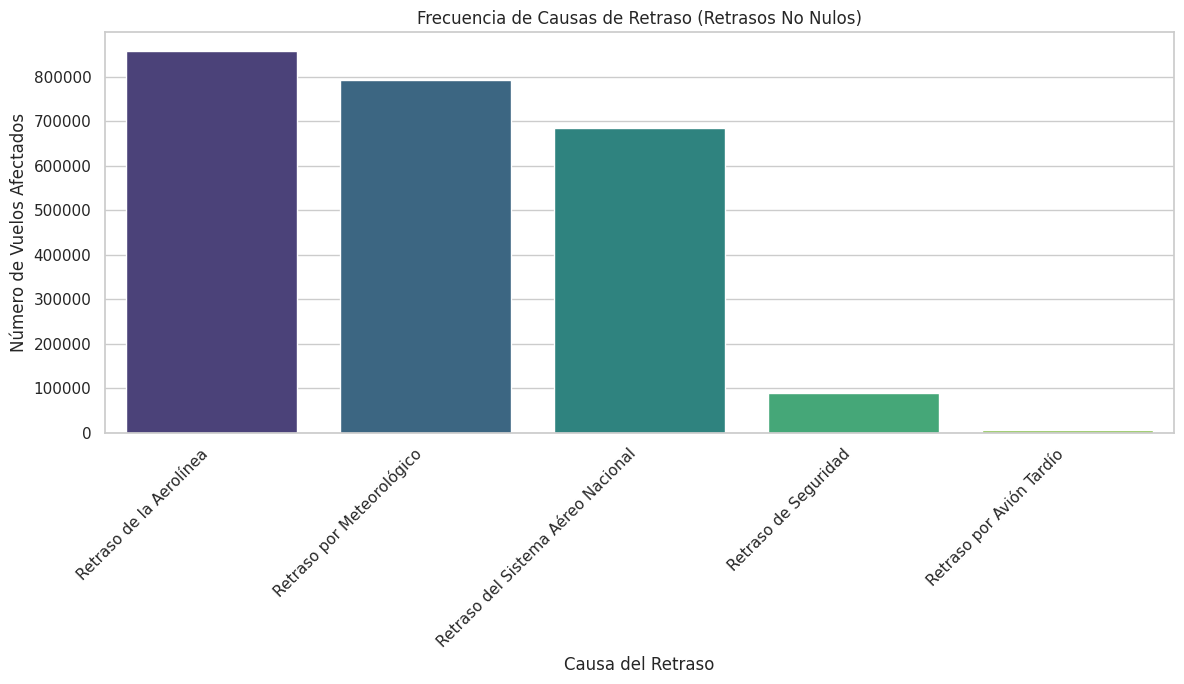

In [15]:
delay_cause_columns = [
    'carrierdelay',
    'weatherdelay',
    'nasdelay',
    'securitydelay',
    'lateaircraftdelay'
]

delay_cause_columns_map = {
    0: 'Retraso de la Aerolínea',
    1: 'Retraso por Meteorológico',
    2: 'Retraso del Sistema Aéreo Nacional',
    3: 'Retraso de Seguridad',
    4: 'Retraso por Avión Tardío',
}


# Count the number of non-zero delays for each cause
frequency_of_causes = {}
for col in delay_cause_columns:
    # A flight is considered to have a delay cause if the delay is > 15
    frequency_of_causes[col] = df.select_dtypes(include='number')[df.select_dtypes(include='number')[col] > 15].shape[0]

# Convert to a pandas Series for easy plotting
frequency_series = pd.Series(frequency_of_causes).sort_values(ascending=False)

sns.set_style("whitegrid")

plt.figure(figsize=(12, 7))
sns.barplot(
    x=frequency_series.index,
    y=frequency_series.values,
    hue=frequency_series.index,
    palette='viridis',
    legend=False
)
plt.title('Frecuencia de Causas de Retraso (Retrasos No Nulos)')
plt.xlabel('Causa del Retraso')
plt.ylabel('Número de Vuelos Afectados')
plt.xticks(
    ticks=range(5),
    labels=[delay_cause_columns_map[i] for i in range(5)],
    rotation=45, ha='right'
)
plt.tight_layout()
plt.show()

## **Probabilidad de retraso de vuelo por hora de salida programada**

In [16]:
# Crear variable temporal 'hour' a partir de la hora programada
df["hour"] = df.select_dtypes(include='number')["crsdeptime"] // 100  # solo la hora

# Variable objetivo 'delayed': 1 si el retraso en salida >= 15 min
df["delayed"] = (df.select_dtypes(include='number')["depdelay"] >= 15).astype(int)

# Probabilidad de delay en la muestra
delay_rate = df["delayed"].mean()
print(f"Delay rate: {delay_rate:.4f}")

# Probabilidad de delay en la muestra
delay_rate = df["delayed"].mean()
print(f"Delay rate: {delay_rate:.4f}")

# Ver valores únicos de la variable 'delayed'
unique_values = df["delayed"].unique()
print("Valores únicos en 'delayed':", unique_values)

Delay rate: 0.1698
Delay rate: 0.1698
Valores únicos en 'delayed': [1 0]


In [17]:
import matplotlib.pyplot as plt

# Agrupar por hora y calcular la probabilidad de retraso
hour_delay = (
    df.groupby("hour")["delayed"]
    .mean()
    .sort_index()
)

# Mostrar la tabla de probabilidades por hora
print(hour_delay)


hour
0     0.180245
1     0.176570
2     0.239925
3     0.256506
4     0.229794
5     0.071609
6     0.074890
7     0.092360
8     0.110538
9     0.128383
10    0.145465
11    0.154597
12    0.168808
13    0.183205
14    0.193270
15    0.201940
16    0.213464
17    0.215501
18    0.230330
19    0.242814
20    0.233717
21    0.242783
22    0.213937
23    0.197289
Name: delayed, dtype: float64


## **Probabilidad de retraso según la distancia de vuelo**

In [18]:
# Crear bins de distancia (5 quintiles)
df["distance_bin"] = pd.qcut(df.select_dtypes(include='number')["distance"], q=5)

# Calcular probabilidad de retraso por rango de distancia
distance_delay = (
    df.groupby("distance_bin", observed=True)["delayed"]
    .mean()
)


print(distance_delay)

distance_bin
(15.999, 305.0]     0.156193
(305.0, 507.0]      0.156351
(507.0, 762.0]      0.167379
(762.0, 1107.0]     0.184747
(1107.0, 5095.0]    0.184449
Name: delayed, dtype: float64


## **Probabilidad de retraso por día de la semana**

In [19]:
# Convertir a datetime (ya hecho en df, pero aseguramos si df_numeric no lo tiene)
# Asumimos que df_numeric y df tienen el mismo índice y número de filas
# y que df['flightdate'] ya es datetime de un paso anterior
df["day_of_week"] = pd.to_datetime(df["flightdate"]).dt.dayofweek

# Map day numbers to day names
days_map = {
    0: 'Lunes',
    1: 'Martes',
    2: 'Miercoles',
    3: 'Jueves',
    4: 'Viernes',
    5: 'Sabado',
    6: 'Domingo'
}

# Calcular probabilidad de retraso por día de la semana
dow_delay = (
    df.groupby("day_of_week")["delayed"]
    .mean()
    .sort_index()
)



## **Top 10 Aerolíneas por probabilidad de retraso**

In [20]:
# Probabilidad de retraso por aerolínea (top 10)
alert_data = (
    df.groupby("marketing_airline_network")["delayed"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

# Mostrar resultados
print(alert_data)



marketing_airline_network
F9    0.257998
B6    0.252006
G4    0.244964
NK    0.203306
WN    0.194534
HA    0.177579
UA    0.168679
AA    0.163093
AS    0.155722
VX    0.143658
Name: delayed, dtype: float64


# **4. Ingeniería de Variables (Feature Engineering)**
---

## **Comprobación de variable objetivo binaria**

In [21]:
df["delayed"].value_counts(normalize=True)

hour_delay = (
    df.groupby("hour")["delayed"]
    .mean()
)

hour_std = hour_delay.std()

print(f"La probabilidad de retraso de los vuelos en promedio\na lo largo de las diferentes horas del día: {hour_std:.2%}")

La probabilidad de retraso de los vuelos en promedio
a lo largo de las diferentes horas del día: 5.49%


---
>
> Este criterio mide cuánto cambia la probabilidad de retraso a lo largo del día;
> si la variación es alta, significa que la hora del vuelo influye de forma real
> en los retrasos, y el ratio entre datasets nos permite comparar cuál captura
> mejor ese patrón temporal sin necesidad de entrenar ni optimizar modelos.
>
> Al medir la variación de la probabilidad de retraso según la hora, verificamos
> que la hora del vuelo tiene impacto real, y usando el ratio podemos decidir
> qué dataset conserva mejor esa señal predictiva sin incurrir en mayor coste
> computacional.



*   Selección de las columnas para el entrenamiento
*   Normalización de nombres a minusculas
*   Elaboración de nuevas variables



In [39]:
# Subsample MVP
N = 5_000
frac = N / len(df)

df_base = (
    df.groupby("year", group_keys=False)
      .sample(frac=frac, random_state=42)
)

df_base.head()

,year,month,dayofmonth,flightdate,marketing_airline_network,origincityname,destcityname,crsdeptime,deptime,depdelay,...,distancegroup,carrierdelay,weatherdelay,nasdelay,securitydelay,lateaircraftdelay,hour,delayed,distance_bin,day_of_week
174634,2018,1,24,2018-01-24,WN,"Chicago, IL","Grand Rapids, MI",2210,2207.0,-3.0,...,1,0.0,0.0,0.0,0.0,0.0,22,0,"(15.999, 305.0]",2
1824459,2018,12,1,2018-12-01,WN,"New Orleans, LA","Atlanta, GA",830,827.0,-3.0,...,2,0.0,0.0,36.0,0.0,0.0,8,0,"(305.0, 507.0]",5
686618,2018,10,5,2018-10-05,DL,"Huntsville, AL","Atlanta, GA",937,929.0,-8.0,...,1,0.0,0.0,0.0,0.0,0.0,9,0,"(15.999, 305.0]",4
1815587,2018,12,8,2018-12-08,UA,"Newark, NJ","Fort Lauderdale, FL",1601,1558.0,-3.0,...,5,0.0,0.0,0.0,0.0,0.0,16,0,"(762.0, 1107.0]",5
708433,2018,10,7,2018-10-07,F9,"Denver, CO","Fort Myers, FL",1548,1538.0,-10.0,...,7,0.0,0.0,0.0,0.0,0.0,15,0,"(1107.0, 5095.0]",6


## Elaboración de dataset predictivo a partir del existente

### Consultar a la API externa sobre el clima para agregar al dataset de entrenamiento

In [40]:
# "Dallas, TX" -> "Dallas"
# Necesario para el geocoding

tmp = (
    df_base["origincityname"]
    .astype(str)
    .str.split(",", n=1, expand=True)
)

df_base["city_clean"] = tmp[0].str.strip()
df_base["state_clean"] = tmp[1].str.strip()  # lo que va después de la coma

df_base[["origincityname", "city_clean", "state_clean"]].head()

,origincityname,city_clean,state_clean
174634,"Chicago, IL",Chicago,IL
1824459,"New Orleans, LA",New Orleans,LA
686618,"Huntsville, AL",Huntsville,AL
1815587,"Newark, NJ",Newark,NJ
708433,"Denver, CO",Denver,CO


In [24]:
print(f'cantidad de ciudades por estado en dataset: {df_base[['city_clean','state_clean']].drop_duplicates().shape}')

cantidad de ciudades por estado en dataset: (274, 2)


In [25]:
print(f'cantidad de ciudades por nombre en dataset: {df_base[['city_clean']].drop_duplicates().shape}')

cantidad de ciudades por nombre en dataset: (269, 1)


Descarga de datos de con ubicación de los aeropuertos

In [26]:
import pandas as pd

URL_AIRPORTS = "https://davidmegginson.github.io/ourairports-data/airports.csv"

# 1) Descargar desde la URL (queda en memoria como DataFrame)
airports = pd.read_csv(URL_AIRPORTS)  # pandas permite leer CSV directo desde URL [web:497]

airports.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,icao_code,iata_code,gps_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total RF Heliport,40.070985,-74.933689,11.0,NaN,US,US-PA,Bensalem,no,NaN,NaN,K00A,00A,https://www.penndot.pa.gov/TravelInPA/airports...,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,NaN,NaN,00AA,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,NaN,NaN,00AK,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,NaN,NaN,00AL,00AL,NaN,NaN,NaN
4,506791,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NaN,US,US-AK,King Salmon,no,NaN,NaN,00AN,00AN,NaN,NaN,NaN


Dejamos solo los aeropuertos de aviacion civil

In [27]:

# 3) (Opcional) Filtrar para aviación civil "normal" (excluye heliports / seaplane)
allowed_types = {"small_airport", "medium_airport", "large_airport"}
airports_civil = airports[airports["type"].isin(allowed_types)].copy()
airports_civil.head()

#iso_regionmunicipality

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,icao_code,iata_code,gps_code,local_code,home_link,wikipedia_link,keywords
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,NaN,NaN,00AA,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,NaN,NaN,00AK,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,NaN,NaN,00AL,00AL,NaN,NaN,NaN
4,506791,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NaN,US,US-AK,King Salmon,no,NaN,NaN,00AN,00AN,NaN,NaN,NaN
5,322127,00AS,small_airport,Fulton Airport,34.942803,-97.818019,1100.0,NaN,US,US-OK,Alex,no,NaN,NaN,00AS,00AS,NaN,NaN,NaN


revisamos la información de un aeropuerto en particular

In [28]:
airport = airports_civil.loc[
    airports_civil["name"].astype(str).str.contains(
        "Odessa" # "Sheremet" "Domodedovo International Airport"
        , case=False, na=False
    )
]

airport

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,icao_code,iata_code,gps_code,local_code,home_link,wikipedia_link,keywords
18073,511360,CCP7,small_airport,Codessa South Airport,55.719801,-118.039116,2000.0,NaN,CA,CA-AB,Eaglesham,no,NaN,NaN,CCP7,CCP7,NaN,https://en.wikipedia.org/wiki/Eaglesham/Codesa...,NaN
20286,46493,CSL7,small_airport,Odessa / Strawberry Lakes Airstrip,50.364518,-103.740807,2160.0,NaN,CA,CA-SK,Qu'Appelle,no,NaN,NaN,CSL7,CSL7,http://www.soar.regina.sk.ca/,https://en.wikipedia.org/wiki/Odessa/Strawberr...,SL7
37495,18774,K43D,small_airport,Odessa Municipal Airport,47.347599,-118.677002,1737.0,NaN,US,US-WA,Odessa,no,NaN,NaN,K43D,43D,NaN,NaN,NaN
40219,20716,KODO,small_airport,Odessa Schlemeyer Field,31.920601,-102.387001,3004.0,NaN,US,US-TX,Odessa,no,NaN,ODT,KODO,ODO,http://www.co.ector.tx.us/default.aspx?Ector_C...,https://en.wikipedia.org/wiki/Odessa-Schlemeye...,"E02, Ector County"
59112,36205,SIQK,small_airport,Nova Odessa Airport,-22.781533,-47.334557,1909.0,SA,BR,BR-SP,Nova Odessa,no,NaN,NaN,SIQK,SP0194,NaN,NaN,Rodrigues
65644,6487,UKOO,medium_airport,Odessa International Airport,46.426800,30.676500,172.0,EU,UA,UA-51,Odessa,yes,UKOO,ODS,UKOO,NaN,http://www.airport.od.ua/,https://en.wikipedia.org/wiki/Odessa_Internati...,"Odesa Central, Міжнародний аеропорт Одеса"


In [29]:
airport['latitude_deg'].dtype

dtype('float64')

extraemos la información de la ubicacion con nombre de la ciudad y estado

In [30]:
# airports: DataFrame ya cargado desde airports.csv (OurAirports)
# airports = pd.read_csv(URL_AIRPORTS)

# 1) Filtrar solo filas donde iso_region empieza con "US-"
df_us = airports.loc[
    airports["iso_region"].astype(str).str.startswith("US-"),
].copy()  # str.startswith para filtrar prefijos [web:526]

# 2) Crear state_clean = parte después del guion (US-AL -> AL)
df_us["state_clean"] = (
    df_us["iso_region"]
      .astype(str)
      .str.split("-", n=1, expand=True)[1]
      .str.strip()
)  # split con expand para crear columnas [web:412][web:405]

# 3) city_clean = municipality (solo renombre/copia)
df_us["city_clean"] = df_us["municipality"].astype(str)
df_us["latitude"] = df_us["latitude_deg"]
df_us["longitude"] = df_us["longitude_deg"]

# 4) Seleccionar columnas finales
df_export = df_us[[
    "type", "name", "latitude", "longitude",
    "state_clean", "city_clean"
]].copy()

df_export.head()


,type,name,latitude,longitude,state_clean,city_clean
0,heliport,Total RF Heliport,40.070985,-74.933689,PA,Bensalem
1,small_airport,Aero B Ranch Airport,38.704022,-101.473911,KS,Leoti
2,small_airport,Lowell Field,59.947733,-151.692524,AK,Anchor Point
3,small_airport,Epps Airpark,34.864799,-86.770302,AL,Harvest
4,small_airport,Katmai Lodge Airport,59.093287,-156.456699,AK,King Salmon


Guarcamos en un archivo CSV

In [31]:
# 5) Exportar a CSV
df_export.to_csv("airports_us_clean.csv", index=False)



In [41]:
df_export = pd.read_csv("airports_us_clean.csv")
df_export.head()

,type,name,latitude,longitude,state_clean,city_clean
0,heliport,Total RF Heliport,40.070985,-74.933689,PA,Bensalem
1,small_airport,Aero B Ranch Airport,38.704022,-101.473911,KS,Leoti
2,small_airport,Lowell Field,59.947733,-151.692524,AK,Anchor Point
3,small_airport,Epps Airpark,34.864799,-86.770302,AL,Harvest
4,small_airport,Katmai Lodge Airport,59.093287,-156.456699,AK,King Salmon


Unimos el dataset de Rafa con las ubicaciones

In [42]:
#merge coordenadas y dataset

df_base = df_base.merge(df_export, on=["city_clean", "state_clean"], how="left")
df_base.head()

,year,month,dayofmonth,flightdate,marketing_airline_network,origincityname,destcityname,crsdeptime,deptime,depdelay,...,hour,delayed,distance_bin,day_of_week,city_clean,state_clean,type,name,latitude,longitude
0,2018,1,24,2018-01-24,WN,"Chicago, IL","Grand Rapids, MI",2210,2207.0,-3.0,...,22,0,"(15.999, 305.0]",2,Chicago,IL,heliport,Children's Memorial Hospital Heliport,41.925598,-87.646400
1,2018,1,24,2018-01-24,WN,"Chicago, IL","Grand Rapids, MI",2210,2207.0,-3.0,...,22,0,"(15.999, 305.0]",2,Chicago,IL,heliport,Vertiport Chicago Heliport,41.862142,-87.670249
2,2018,1,24,2018-01-24,WN,"Chicago, IL","Grand Rapids, MI",2210,2207.0,-3.0,...,22,0,"(15.999, 305.0]",2,Chicago,IL,heliport,University of Chicago Hospitals Heliport,41.788399,-87.604202
3,2018,1,24,2018-01-24,WN,"Chicago, IL","Grand Rapids, MI",2210,2207.0,-3.0,...,22,0,"(15.999, 305.0]",2,Chicago,IL,heliport,Rose Nr 3 Heliport,41.812500,-87.663101
4,2018,1,24,2018-01-24,WN,"Chicago, IL","Grand Rapids, MI",2210,2207.0,-3.0,...,22,0,"(15.999, 305.0]",2,Chicago,IL,heliport,Presence Sts Mary and Elizabeth Medical Center...,41.902802,-87.682800


In [43]:
df_base.shape

(147759, 39)

In [44]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147759 entries, 0 to 147758
Data columns (total 39 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   year                       147759 non-null  int64   
 1   month                      147759 non-null  int64   
 2   dayofmonth                 147759 non-null  int64   
 3   flightdate                 147759 non-null  object  
 4   marketing_airline_network  147759 non-null  object  
 5   origincityname             147759 non-null  object  
 6   destcityname               147759 non-null  object  
 7   crsdeptime                 147759 non-null  int64   
 8   deptime                    147759 non-null  float64 
 9   depdelay                   147759 non-null  float64 
 10  depdelayminutes            147759 non-null  float64 
 11  taxiout                    147759 non-null  float64 
 12  wheelsoff                  147759 non-null  float64 
 13  wheelson      

Consultamos el clima historico


En este codigo excluyimos el año 2018 consultado y guardado anteriormente en **openmeteo_daily_cache.parquet**. Submos ese archivo a workspace temporal del notebook y le agregamos el resto de los años

In [45]:
# código completo incorporando selección balanceada por año para keys_missing,
# de modo que cuando pidas max_api_calls=15000 no se vaya todo al primer año (p. ej. 2018),
# sino que tome una cantidad similar por año (y si un año tiene pocas claves faltantes, toma todas y redistribuye el resto).
#  La parte clave es usar groupby(...).apply(lambda g: g.sample(...)) para muestrear por grupo/año.

import os
import time
import math
import fcntl  # En Windows reemplaza por msvcrt.locking si lo necesitas
import requests
import pandas as pd

BASE_URL = "https://archive-api.open-meteo.com/v1/archive"
HARD_CAP = 5_000          # límite duro (tu tope global) — respeta tu configuración
DEFAULT_TIMEOUT = 15
MAX_RETRIES = 3
BACKOFF_BASE = 0.75        # segundos
WRITE_BATCH_SIZE = 500     # cada cuántas respuestas persistimos


def _safe_sleep(last_call_ts, min_interval_s):
    now = time.time()
    wait = (last_call_ts + min_interval_s) - now
    if wait > 0:
        time.sleep(wait)
    return time.time()


def _retry_get(session, url, params, timeout=DEFAULT_TIMEOUT, max_retries=MAX_RETRIES):
    for attempt in range(1, max_retries + 1):
        try:
            r = session.get(url, params=params, timeout=timeout)
            r.raise_for_status()
            return r
        except requests.RequestException:
            if attempt == max_retries:
                raise
            back = BACKOFF_BASE * (2 ** (attempt - 1))
            time.sleep(back)
    raise RuntimeError("Exhausted retries unexpectedly")


def fetch_daily_weather_for_point_date(lat, lon, date_str, timezone="UTC", session=None, timeout=DEFAULT_TIMEOUT):
    params = {
        "latitude": float(lat),
        "longitude": float(lon),
        "start_date": date_str,
        "end_date": date_str,
        "daily": "temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max",
        "timezone": timezone,
    }
    s = session or requests.Session()
    r = _retry_get(s, BASE_URL, params=params, timeout=timeout, max_retries=MAX_RETRIES)
    data = r.json()

    d = data.get("daily", {})
    row = {
        "flightdate": date_str,
        "temp_max": d.get("temperature_2m_max", [None])[0],
        "temp_min": d.get("temperature_2m_min", [None])[0],
        "precipitation_sum": d.get("precipitation_sum", [None])[0],
        "wind_speed_max": d.get("windspeed_10m_max", [None])[0],
    }
    if row["temp_max"] is not None and row["temp_min"] is not None:
        row["temp_mean"] = (float(row["temp_max"]) + float(row["temp_min"])) / 2.0
    else:
        row["temp_mean"] = None
    return row


def _ensure_dir(path):
    d = os.path.dirname(os.path.abspath(path))
    if d and not os.path.exists(d):
        os.makedirs(d, exist_ok=True)


def _lock_file(path, mode="a+b"):
    f = open(path, mode)
    try:
        fcntl.flock(f.fileno(), fcntl.LOCK_EX)
    except Exception:
        f.close()
        raise
    return f


def _write_parquet_atomic(df: pd.DataFrame, path: str, tmp_suffix=".tmp"):
    tmp_path = f"{path}{tmp_suffix}"
    df.to_parquet(tmp_path, index=False)
    os.replace(tmp_path, path)


def _load_cache(cache_path: str) -> pd.DataFrame:
    cols = ["_lat_r","_lon_r","flightdate","temp_max","temp_min","temp_mean","precipitation_sum","wind_speed_max"]
    if os.path.exists(cache_path):
        try:
            df_cache = pd.read_parquet(cache_path)
            for c in cols:
                if c not in df_cache.columns:
                    df_cache[c] = pd.Series(dtype="float64" if c.startswith("temp") or c in ["precipitation_sum","wind_speed_max"] else "object")
            df_cache = df_cache.drop_duplicates(subset=["_lat_r", "_lon_r", "flightdate"], keep="last")
            return df_cache
        except Exception:
            corrupt = cache_path + ".corrupt"
            os.replace(cache_path, corrupt)
            print(f"[cache] Archivo corrupto movido a: {corrupt}. Se reinicia cache.")
    return pd.DataFrame(columns=cols)


def _balance_keys_by_year(keys_missing: pd.DataFrame, max_api_calls: int, random_state: int = 42, exclude_years=None) -> pd.DataFrame:
    """
    Devuelve un subconjunto de keys_missing, muestreado de forma balanceada por 'year'
    derivado desde flightdate. Usa groupby+sample. [web:696][web:712]
    """
    exclude_years = set(exclude_years or [])
    km = keys_missing.copy()
    km["year"] = pd.to_datetime(km["flightdate"], errors="coerce").dt.year

    if exclude_years:
        km = km[~km["year"].isin(exclude_years)].copy()

    # Si no hay year parseable, fallback a sample global
    years = sorted(km["year"].dropna().unique())
    if len(years) == 0:
        out = km.sample(n=min(len(km), max_api_calls), random_state=random_state)
        return out.drop(columns=["year"], errors="ignore")

    # Target por año
    per_year = math.ceil(max_api_calls / len(years))

    # Sample por grupo/año (sin reemplazo; si hay menos, toma todo)
    sampled = (
        km.groupby("year", group_keys=False)
          .apply(lambda g: g.sample(n=min(len(g), per_year), random_state=random_state))
    )

    # Si sobraron por ceil, recorta a max_api_calls; si faltaron, rellena con el resto
    if len(sampled) > max_api_calls:
        sampled = sampled.sample(n=max_api_calls, random_state=random_state)

    elif len(sampled) < max_api_calls:
        picked_keys = (
            sampled["_lat_r"].astype(str) + "|" +
            sampled["_lon_r"].astype(str) + "|" +
            sampled["flightdate"].astype(str)
        )
        picked_set = set(picked_keys.values)

        all_keys = (
            km["_lat_r"].astype(str) + "|" +
            km["_lon_r"].astype(str) + "|" +
            km["flightdate"].astype(str)
        )
        rest = km.loc[~all_keys.isin(picked_set)]
        need = max_api_calls - len(sampled)
        if len(rest) > 0 and need > 0:
            sampled = pd.concat(
                [sampled, rest.sample(n=min(len(rest), need), random_state=random_state)],
                ignore_index=True
            )

    return sampled.drop(columns=["year"], errors="ignore")


def enrich_df_base_with_weather_daily_cached(
    df_base: pd.DataFrame,
    timezone="UTC",
    max_requests_per_second=2.0,
    max_api_calls=20000,
    round_coords_decimals=3,
    cache_path="openmeteo_daily_cache.parquet",
    show_progress=True,
    random_state=42,
    exclude_years=None,        # ej: [2018] si quieres saltarte 2018
) -> pd.DataFrame:

    max_api_calls = min(int(max_api_calls), HARD_CAP)
    _ensure_dir(cache_path)

    # Normaliza fechas y claves
    df = df_base.copy()
    df["flightdate"] = pd.to_datetime(df["flightdate"]).dt.strftime("%Y-%m-%d")
    df["_lat_r"] = df["latitude"].round(round_coords_decimals)
    df["_lon_r"] = df["longitude"].round(round_coords_decimals)

    keys = (
        df.loc[df["_lat_r"].notna() & df["_lon_r"].notna(), ["_lat_r", "_lon_r", "flightdate"]]
          .drop_duplicates()
          .reset_index(drop=True)
    )

    # Carga cache
    df_cache = _load_cache(cache_path)

    # Anti-join vectorizado
    if not df_cache.empty:
        cache_key = (
            df_cache["_lat_r"].astype(str) + "|" +
            df_cache["_lon_r"].astype(str) + "|" +
            df_cache["flightdate"].astype(str)
        )
        cached_set = set(cache_key.values)
    else:
        cached_set = set()

    keys_key = keys["_lat_r"].astype(str) + "|" + keys["_lon_r"].astype(str) + "|" + keys["flightdate"].astype(str)
    missing_mask = ~keys_key.isin(cached_set)
    keys_missing = keys.loc[missing_mask].reset_index(drop=True)

    total_missing = len(keys_missing)
    if total_missing == 0:
        print(f"[ok] No hay claves faltantes. Cache: {len(df_cache)} filas. Archivo: {os.path.abspath(cache_path)}")

    # IMPORTANTE: balancea por año ANTES de aplicar el cap final
    if total_missing > 0:
        keys_missing = _balance_keys_by_year(
            keys_missing=keys_missing,
            max_api_calls=max_api_calls,
            random_state=random_state,
            exclude_years=exclude_years
        )

    to_fetch = len(keys_missing)
    print(f"[plan] Únicas totales: {len(keys)} | En cache: {len(cached_set)} | A consultar: {to_fetch} (cap máx: {HARD_CAP})")

    if to_fetch == 0:
        df_enriched = df.merge(
            df_cache.drop_duplicates(subset=["_lat_r","_lon_r","flightdate"], keep="last"),
            how="left",
            on=["_lat_r","_lon_r","flightdate"]
        )
        df_enriched.drop(columns=["_lat_r", "_lon_r"], inplace=True)
        return df_enriched

    # Rate limit
    min_interval_s = 1.0 / max_requests_per_second if max_requests_per_second > 0 else 0.0
    last_call_ts = 0.0
    session = requests.Session()

    # Barra de progreso opcional
    try:
        from tqdm import tqdm
        bar = tqdm(total=to_fetch, unit="req", disable=not show_progress)
    except Exception:
        bar = None
        print("[info] tqdm no disponible. Continuando sin barra de progreso.")

    new_rows = []
    written_since_last = 0
    processed = 0
    start_ts = time.time()

    def persist_incremental(df_cache_local, new_rows_batch):
        if not new_rows_batch:
            return df_cache_local
        df_new_local = pd.DataFrame(new_rows_batch)
        df_cache_local = pd.concat([df_cache_local, df_new_local], ignore_index=True)
        df_cache_local = df_cache_local.drop_duplicates(subset=["_lat_r","_lon_r","flightdate"], keep="last")
        with _lock_file(cache_path, mode="a+b"):
            _write_parquet_atomic(df_cache_local, cache_path)
        return df_cache_local

    for _, k in keys_missing.iterrows():
        if processed >= HARD_CAP:
            break

        last_call_ts = _safe_sleep(last_call_ts, min_interval_s)

        try:
            row = fetch_daily_weather_for_point_date(
                lat=k["_lat_r"], lon=k["_lon_r"], date_str=k["flightdate"],
                timezone=timezone, session=session
            )
            row["_lat_r"] = k["_lat_r"]
            row["_lon_r"] = k["_lon_r"]
        except requests.RequestException:
            row = {
                "_lat_r": k["_lat_r"],
                "_lon_r": k["_lon_r"],
                "flightdate": k["flightdate"],
                "temp_max": None,
                "temp_min": None,
                "temp_mean": None,
                "precipitation_sum": None,
                "wind_speed_max": None,
            }

        new_rows.append(row)
        processed += 1
        written_since_last += 1

        if bar:
            bar.update(1)
            elapsed = max(time.time() - start_ts, 1e-6)
            rate = processed / elapsed
            remaining = to_fetch - processed
            eta = remaining / rate if rate > 0 else float("inf")
            bar.set_postfix({"rate": f"{rate:.2f}/s", "ETA": f"{eta/60:.1f}m"})

        if written_since_last >= WRITE_BATCH_SIZE:
            df_cache = persist_incremental(df_cache, new_rows)
            print(f"[persist] Escrito batch de {written_since_last}. Total cache: {len(df_cache)}")
            new_rows.clear()
            written_since_last = 0

    if new_rows:
        df_cache = persist_incremental(df_cache, new_rows)
        print(f"[persist] Escrito batch final de {len(new_rows)}. Total cache: {len(df_cache)}")
        new_rows.clear()

    if bar:
        bar.close()

    # Merge final
    df_enriched = df.merge(
        df_cache.drop_duplicates(subset=["_lat_r","_lon_r","flightdate"], keep="last"),
        how="left",
        on=["_lat_r","_lon_r","flightdate"]
    )
    df_enriched.drop(columns=["_lat_r", "_lon_r"], inplace=True)

    print(f"[done] Enriquecidas {len(df_enriched)} filas. Cache en: {os.path.abspath(cache_path)}")
    return df_enriched


# ---- Ejemplo de uso ----
# 1) Si ya tienes 15k de 2018 y quieres priorizar otros años:
# df_base = enrich_df_base_with_weather_daily_cached(
#     df_base,
#     timezone="auto",
#     max_requests_per_second=2.0,
#     max_api_calls=15000,
#     round_coords_decimals=3,
#     cache_path="openmeteo_daily_cache.parquet",
#     exclude_years=[2018],   # opcional
#     random_state=42
# )


Ejecutamos la llamada a la función que consulta la API y extiende el archivo cache.

In [38]:
# ---- Uso ----

# 2) O balancear excluyendo año 2018:
df_base = enrich_df_base_with_weather_daily_cached(
    df_base,
    timezone="auto",
    max_requests_per_second=2.0,
    max_api_calls=2500,
    round_coords_decimals=3,
    cache_path="openmeteo_daily_cache.parquet",
    exclude_years=[2018],   # <- aquí
    random_state=42
)

/tmp/ipython-input-1484991348.py:134: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(len(g), per_year), random_state=random_state))


[plan] Únicas totales: 133691 | En cache: 18000 | A consultar: 2500 (cap máx: 5000)



  1%|▏         | 33/2500 [00:16<20:17,  2.03req/s, rate=2.03/s, ETA=20.2m]

KeyboardInterrupt: 

Exportamos parquea a CSV

In [40]:
df_base.to_csv("dataset_con_meteo_out.csv", index=False, encoding="utf-8")

Cargamos CSV a DataFrame

In [50]:
df = pd.read_csv("dataset_con_meteo_out.csv")

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147759 entries, 0 to 147758
Data columns (total 39 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   year                       147759 non-null  int64  
 1   month                      147759 non-null  int64  
 2   dayofmonth                 147759 non-null  int64  
 3   flightdate                 147759 non-null  object 
 4   marketing_airline_network  147759 non-null  object 
 5   origincityname             147759 non-null  object 
 6   destcityname               147759 non-null  object 
 7   crsdeptime                 147759 non-null  int64  
 8   deptime                    147759 non-null  float64
 9   depdelay                   147759 non-null  float64
 10  depdelayminutes            147759 non-null  float64
 11  taxiout                    147759 non-null  float64
 12  wheelsoff                  147759 non-null  float64
 13  wheelson                   14

In [52]:
df.head()

,year,month,dayofmonth,flightdate,marketing_airline_network,origincityname,destcityname,crsdeptime,deptime,depdelay,...,hour,delayed,distance_bin,day_of_week,city_clean,state_clean,type,name,latitude,longitude
0,2018,1,24,2018-01-24,WN,"Chicago, IL","Grand Rapids, MI",2210,2207.0,-3.0,...,22,0,"(15.999, 305.0]",2,Chicago,IL,heliport,Children's Memorial Hospital Heliport,41.925598,-87.646400
1,2018,1,24,2018-01-24,WN,"Chicago, IL","Grand Rapids, MI",2210,2207.0,-3.0,...,22,0,"(15.999, 305.0]",2,Chicago,IL,heliport,Vertiport Chicago Heliport,41.862142,-87.670249
2,2018,1,24,2018-01-24,WN,"Chicago, IL","Grand Rapids, MI",2210,2207.0,-3.0,...,22,0,"(15.999, 305.0]",2,Chicago,IL,heliport,University of Chicago Hospitals Heliport,41.788399,-87.604202
3,2018,1,24,2018-01-24,WN,"Chicago, IL","Grand Rapids, MI",2210,2207.0,-3.0,...,22,0,"(15.999, 305.0]",2,Chicago,IL,heliport,Rose Nr 3 Heliport,41.812500,-87.663101
4,2018,1,24,2018-01-24,WN,"Chicago, IL","Grand Rapids, MI",2210,2207.0,-3.0,...,22,0,"(15.999, 305.0]",2,Chicago,IL,heliport,Presence Sts Mary and Elizabeth Medical Center...,41.902802,-87.682800


In [53]:
df.shape

(147759, 39)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147759 entries, 0 to 147758
Data columns (total 39 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   year                       147759 non-null  int64  
 1   month                      147759 non-null  int64  
 2   dayofmonth                 147759 non-null  int64  
 3   flightdate                 147759 non-null  object 
 4   marketing_airline_network  147759 non-null  object 
 5   origincityname             147759 non-null  object 
 6   destcityname               147759 non-null  object 
 7   crsdeptime                 147759 non-null  int64  
 8   deptime                    147759 non-null  float64
 9   depdelay                   147759 non-null  float64
 10  depdelayminutes            147759 non-null  float64
 11  taxiout                    147759 non-null  float64
 12  wheelsoff                  147759 non-null  float64
 13  wheelson                   14

Cambiamos nombres de las columnas nuevas agregadas anteriormente

In [54]:
df = df.rename(columns={
    "precipitation_sum": "precipitation",
    "wind_speed_max": "wind_speed",
})

Revisamos cuantos nulos tienen estas columnas

In [56]:
df[["temp_mean", "precipitation", "wind_speed"]].isna().sum()

KeyError: "None of [Index(['precipitation', 'wind_speed'], dtype='object')] are in the [columns]"

revisasmo cuantos nulos tiene dataset agrupado por año

In [ ]:
# null por años
cols = ["temp_mean", "precipitation", "wind_speed"]

mask_any_na = df[cols].isna().any(axis=1)
na_rows_by_year = df.loc[mask_any_na].groupby("year").size().sort_index()

na_rows_by_year

,0
year,
2018,11112
2019,24672
2020,26047
2021,23160
2022,25477
2023,23637


revisamos cuantos no NULL ttenemos por año

In [ ]:
# No-null por año (para columnas específicas)

cols = ["temp_mean", "precipitation", "wind_speed"]

not_null_by_year = df.groupby("year")[cols].count().sort_index()
not_null_by_year

,temp_mean,precipitation,wind_speed
year,,,
2018,13654,13654,13654
2019,0,0,0
2020,0,0,0
2021,0,0,0
2022,0,0,0
2023,0,0,0


revisamos la muestra de datos

In [ ]:
df.loc[mask_any_na, ["year", "flightdate"] + cols].sample(20)

,year,flightdate,temp_mean,precipitation,wind_speed
119169,2022,2022-11-09,NaN,NaN,NaN
74035,2020,2020-11-15,NaN,NaN,NaN
38499,2019,2019-01-12,NaN,NaN,NaN
2949,2018,2018-12-10,NaN,NaN,NaN
30016,2019,2019-10-02,NaN,NaN,NaN
27245,2019,2019-12-22,NaN,NaN,NaN
65688,2020,2020-12-12,NaN,NaN,NaN
79705,2021,2021-11-24,NaN,NaN,NaN
92323,2021,2021-10-18,NaN,NaN,NaN
75740,2021,2021-11-02,NaN,NaN,NaN


eliminamos toda la data con nulos en las columnas nuevas. dejamos solo la que tiene informacion de clima

In [ ]:
# Eliminamos filas sin información climática

df_ml = df.dropna(
    subset=["temp_mean", "precipitation", "wind_speed"]
)

df_ml.shape

exportamos el dataset nuevo a CSV y lo descargamos en forma forzada

In [ ]:
OUTPUT_CSV = "dataset_vuelos_clima_final.csv"
df_ml.to_csv(OUTPUT_CSV, index=False)

OUTPUT_CSV

from google.colab import files
files.download(OUTPUT_CSV)